In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import functools

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from PIL import Image
import numpy as np

from photutils import detect_threshold
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
from photutils import deblend_sources
import skimage
import statsmodels.api as sm

# Results

1. Masters 2019 No Bulge-Winding Correlation is also true of DECALS (naive replication)
2. Picking `Bulge Moderate - Small` to as the metric for bulge size, you can get an anti-correlation (bigger bulge <-> looser arms)
3. **Volunteers pick galaxies as having larger bulges when the picture is more 'zoomed-in'**

## Load DECALS Catalog To-Date

In [3]:
!pwd

/Data/repos/zoobot/notebooks


In [4]:
!ls ../data/decals/prepared_catalogs/smooth_unfiltered*

../data/decals/prepared_catalogs/smooth_unfiltered.dvc

../data/decals/prepared_catalogs/smooth_unfiltered:
full_catalog.csv       simulation_context
labelled_catalog.csv   unlabelled_catalog.csv


In [5]:
df = pd.read_csv('../data/decals/decals_master_catalog.csv')

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (100,108,116,122,130,138,144,152,166,178,204) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Apply General Sample Cuts From Masters 2019

In [6]:
len(df)

339803

In [7]:
df = df[df['smooth-or-featured_total-votes'] > 0]

In [8]:
len(df)

45162

In [9]:
df = df[(df['redshift'] < 0.035) & (df['redshift'] > 0.01)]

In [10]:
len(df)

4160

In [11]:
df = df[df['smooth-or-featured_artifact_fraction'] < 0.5]

In [12]:
len(df)

4136

In [13]:
df = df[df['smooth-or-featured_total-votes'] < 50]

In [14]:
len(df)

4126

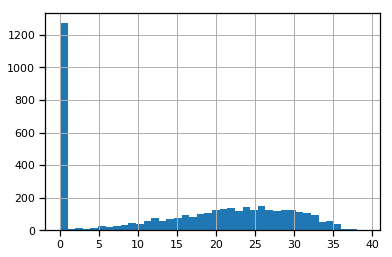

In [15]:
df['merging_none'].hist(bins=40)

In [16]:
df = df[df['merging_none'] > 3]  # not exactly the same, but aiming to identify 'normal' galaxies

In [17]:
len(df)  # to check, could be over-eager

2821

## Apply Face-On Spiral Cuts (as per Masters 2019)

In [18]:
df = df[df['smooth-or-featured_featured-or-disk_fraction'] > 0.43]
df = df[df['disk-edge-on_no_fraction'] > 0.715]
df = df[df['has-spiral-arms_yes_fraction'] > 0.619]

In [19]:
len(df)

624

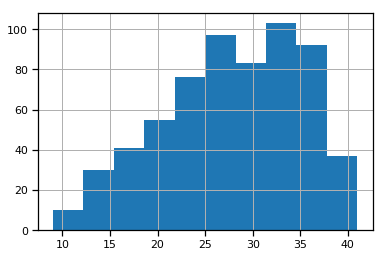

In [20]:
df['spiral-winding_total-votes'].hist()

In [21]:
df = df[df['spiral-winding_total-votes'] > 20]

In [22]:
len(df)

505

## Define Winding and Bulge Metrics, as per Masters 2019

In [23]:
df['winding_eqn_1'] = df['spiral-winding_tight_fraction'] + 0.5 * df['spiral-winding_medium_fraction']

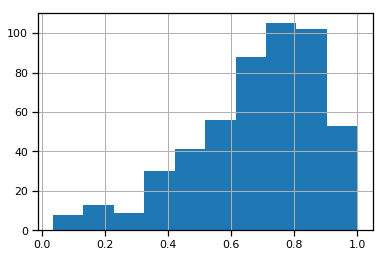

In [24]:
df['winding_eqn_1'].hist()

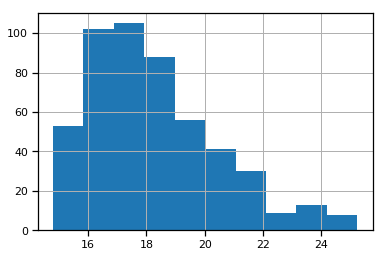

In [25]:
df['winding_eqn_2'] = 25.6 - 10.8 * df['winding_eqn_1']
df['winding_eqn_2'].hist()

In [26]:
df['bulge_eqn_3'] = 0.25 * df['bulge-size_small_fraction'] + 0.5 * df['bulge-size_moderate_fraction'] + 0.75 * df['bulge-size_large_fraction'] + df['bulge-size_dominant_fraction']

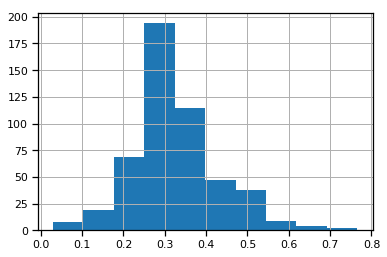

In [27]:
df['bulge_eqn_3'].hist()

## Replicate Masters 2019 Result with DECALS

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


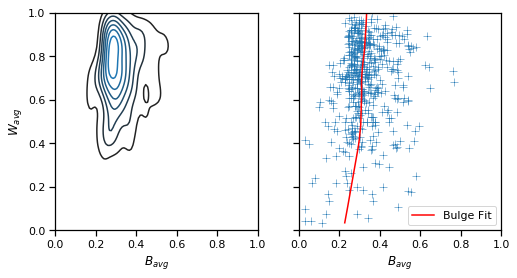

In [28]:
# fig, ax = plt.subplots(figsize=(6, 5))
# sns.kdeplot(df['bulge_eqn_3'], df['winding_eqn_1'], ax=ax)

# ax.set_xlim([0., 1.])
# ax.set_ylim([0., 1.])
# fig.tight_layout()

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
sns.kdeplot(df['bulge_eqn_3'], df['winding_eqn_1'], ax=ax0)
sns.scatterplot(df['bulge_eqn_3'], df['winding_eqn_1'], s=50, edgecolor="b", linewidth=.5, marker='+', ax=ax1)
ax0.set_xlim([0, 1])
ax0.set_ylim([0, 1])
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax0.set_ylabel(r'$W_{avg}$')
ax0.set_xlabel(r'$B_{avg}$')
ax1.set_xlabel(r'$B_{avg}$')

z = sm.nonparametric.lowess(df['bulge_eqn_3'], df['winding_eqn_1'])
ax1.plot(z[:, 1], z[:, 0], c='r', label='Bulge Fit')
ax1.legend()

Looks similar - no correlation between winding and bar size. Good stuff.

However, the winding and bulge metric definitions are a bit arbitrary. What if we choose:
1. Direct correlations between answers, without summarising into metrics?
2. Other reasonable metrics?

## 1. Investigate Direct Correlations Without New Metrics

Rename for the sake of small axis labels

In [29]:
df['bulge_small_fraction'] = df['bulge-size_small_fraction']
df['bulge_moderate_fraction'] = df['bulge-size_moderate_fraction']
df['spiral_tight_fraction'] = df['spiral-winding_tight_fraction']
df['spiral_medium_fraction'] = df['spiral-winding_medium_fraction']
df['spiral_loose_fraction'] = df['spiral-winding_loose_fraction']

Look for correlations between the common answers

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


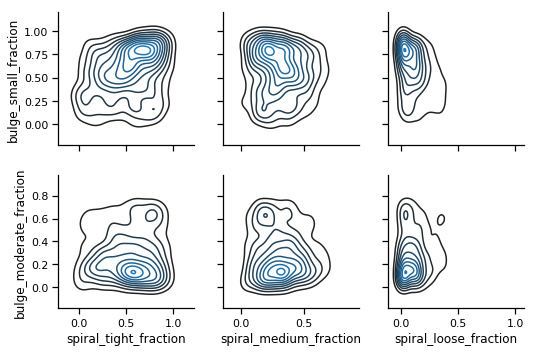

In [30]:
g = sns.PairGrid(
    df,
    y_vars=['bulge_small_fraction', 'bulge_moderate_fraction'], 
    x_vars=['spiral_tight_fraction', 'spiral_medium_fraction', 'spiral_loose_fraction'],
)
g = g.map(sns.kdeplot)

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


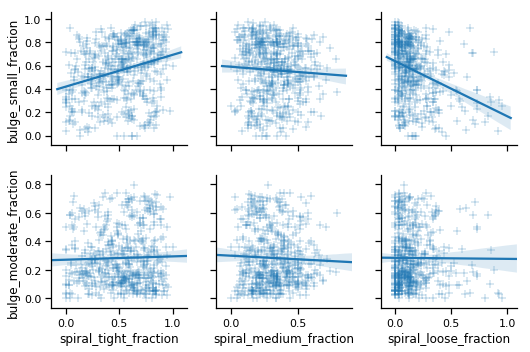

In [31]:
g = sns.PairGrid(
    df,
    y_vars=['bulge_small_fraction', 'bulge_moderate_fraction'], 
    x_vars=['spiral_tight_fraction', 'spiral_medium_fraction', 'spiral_loose_fraction'],
)
g = g.map(sns.regplot, marker='+', scatter_kws=dict(s=50, edgecolor="k", linewidth=.4))

For each answer pair, there's no obvious correlations across the whole sample. 

**There does seem to be some interesting structure, though - there seem to be local correlations.**

For example, for bulge small > 0.25, bulge_small seems to correlate with spiral_tight and anti-correlates with spiral_medium. But it's all quite unclear.

## 2. Investigate Other Reasonable Metrics

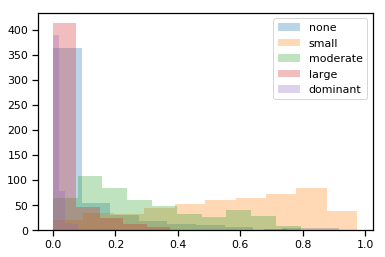

In [32]:
fig, ax = plt.subplots()
alpha = 0.3
ax.hist(df['bulge-size_none_fraction'], alpha=alpha, label='none')
ax.hist(df['bulge-size_small_fraction'], alpha=alpha, label='small')
ax.hist(df['bulge-size_moderate_fraction'], alpha=alpha, label='moderate')
ax.hist(df['bulge-size_large_fraction'], alpha=alpha, label='large')
ax.hist(df['bulge-size_dominant_fraction'], alpha=alpha, label='dominant')
ax.legend()

Large, None and Dominant are quite rare.

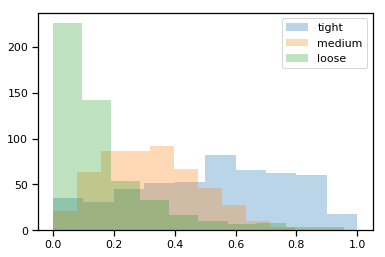

In [33]:
fig, ax = plt.subplots()
alpha = 0.3
df['winding_eqn_1'] = df['spiral-winding_tight_fraction'] + 0.5 * df['spiral-winding_medium_fraction']
ax.hist(df['spiral-winding_tight_fraction'], alpha=alpha, label='tight')
ax.hist(df['spiral-winding_medium_fraction'], alpha=alpha, label='medium')
ax.hist(df['spiral-winding_loose_fraction'], alpha=alpha, label='loose')
ax.legend()

Tight is most popular, followed by medium, with loose being quite rare. **Lets use tight - medium as our metric.**

In [35]:
df['spiral-tight-minus-loose'] = df['spiral-winding_tight_fraction'] - df['spiral-winding_loose_fraction']
df['spiral-tight-minus-medium'] = df['spiral-winding_tight_fraction'] - df['spiral-winding_medium_fraction']
df['bulge_moderate-minus-small'] =  df['bulge-size_moderate_fraction'] - df['bulge-size_small_fraction']


In [36]:
# fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
# sns.kdeplot(df['bulge_moderate-minus-small'], df['spiral-tight-minus-loose'], ax=ax0)
# sns.scatterplot(df['bulge_moderate-minus-small'], df['spiral-tight-minus-loose'], s=50, edgecolor="b", linewidth=.5, marker='+', ax=ax1)
# ax0.set_xlim([-1, 1])
# ax0.set_ylim([-1, 1])
# ax0.set_xlabel('Bulge Moderate - Small')
# ax0.set_ylabel('Spiral Tight - Loose')

# z = sm.nonparametric.lowess(df['bulge_moderate-minus-small'], df['spiral-tight-minus-loose'])
# ax1.plot(z[:, 1], z[:, 0], c='r', label='Bulge Fit')
# ax1.legend()

In [37]:
# Maybe a correlation, but the bulge_moderate > 0. look like a seperate population that don't follow the trend.

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


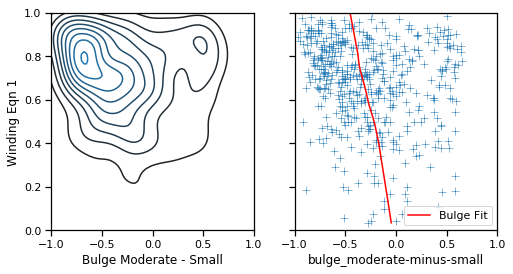

In [38]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
sns.kdeplot(df['bulge_moderate-minus-small'], df['winding_eqn_1'], ax=ax0)
sns.scatterplot(df['bulge_moderate-minus-small'], df['winding_eqn_1'], s=50, edgecolor="b", linewidth=.5, marker='+', ax=ax1)
ax0.set_xlim([-1, 1])
ax0.set_ylim([0, 1])
ax0.set_xlabel('Bulge Moderate - Small')
ax0.set_ylabel('Winding Eqn 1')

z = sm.nonparametric.lowess(df['bulge_moderate-minus-small'], df['winding_eqn_1'])
ax1.plot(z[:, 1], z[:, 0], c='r', label='Bulge Fit')
ax1.legend()

Maybe a correlation, but the bulge_moderate > 0. look like a seperate population that don't follow the trend.

In [39]:
# fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
# sns.kdeplot(df['bulge_moderate-minus-small'], df['spiral-tight-minus-medium'], ax=ax0)
# sns.scatterplot(df['bulge_moderate-minus-small'], df['spiral-tight-minus-medium'], s=50, edgecolor="b", linewidth=.5, marker='+', ax=ax1)
# ax0.set_xlim([-1, 1])
# ax0.set_ylim([-1, 1])
# ax0.set_xlabel('Bulge Moderate - Small')
# ax0.set_ylabel('Spiral Tight - Medium')

In [66]:
def show_examples(examples, n_examples=10, crop=0):
    im_size = 424
    images = [Image.open(x) for x in examples['local_png_loc'][:n_examples]]
    cropped_images = [x.crop((crop, crop, 424 - crop, 424 - crop)) for x in images]
    show_images(cropped_images)



In [67]:
def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(3 * len(images), 3))
    for axes_n, ax in enumerate(axes):
        ax.imshow(np.array(images[axes_n]))
        ax.grid(False)
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

In [86]:
def get_segmentation_mask(image):
    data = image.mean(axis=2)
    threshold = detect_threshold(data, snr=2.)
    sigma = 4.0 * gaussian_fwhm_to_sigma
    kernel = Gaussian2DKernel(sigma, x_size=2, y_size=2)
    kernel.normalize()
    segm = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)
    deblended = deblend_sources(data, segm, npixels=5, filter_kernel=kernel, nlevels=3, contrast=0.7)
    deblended.relabel_sequential()
    return deblended

In [87]:
def get_segmentation_masks(examples, n_examples=10):
    images = [np.array(Image.open(x)) for x in examples['local_png_loc'][:n_examples]]
    segm_masks = [get_segmentation_mask(x) for x in images]
    return segm_masks


In [88]:
def show_segmentation(masks):
    show_images(masks)
#     print([get_pc_area_of_main_segm_region(x) for x in masks])
#     print([int(x.area(1)) / (424 * 424) for x in masks])

In [89]:
def get_main_segm_region(segm):
    max_area = 0
    for n in range(1, segm.data.max()):
        area = np.max(segm.area(n))
        if area > max_area:
            max_area = area
            max_n = n
    return max_n, max_area
    

In [68]:
bulk = df[(df['bulge_moderate-minus-small'] < -0.5) & (df['spiral-tight-minus-loose'] > 0.25)]
top_right = df[(df['bulge_moderate-minus-small'] > 0.4) & (df['spiral-tight-minus-loose'] > 0.25)]


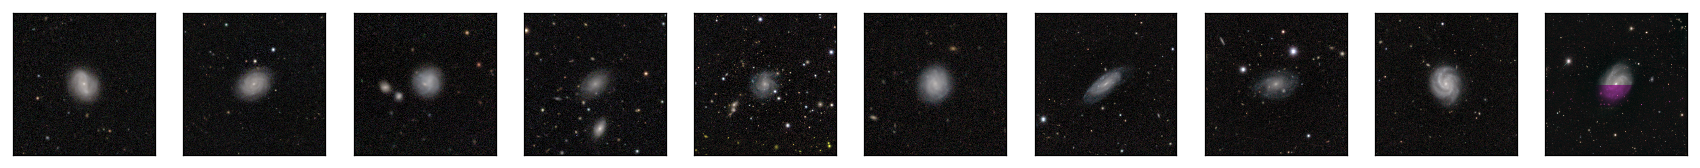

In [69]:
show_examples(bulk, 10)

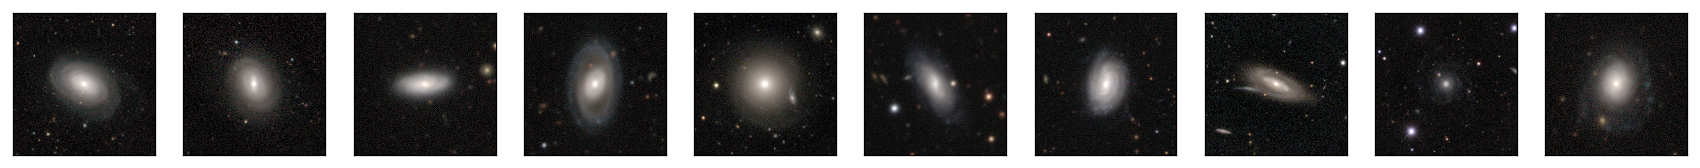

In [70]:
show_examples(top_right, 10)

**The lower galaxies obviously appear larger!**


### Quantify How Large Galaxies are With Segmentation

[25.20990566037736, 25.181603773584907, 20.964622641509433, 15.325471698113208, 14.974056603773585, 27.754716981132077, 17.441037735849058, 19.858490566037737, 27.566037735849058, 27.41745283018868]


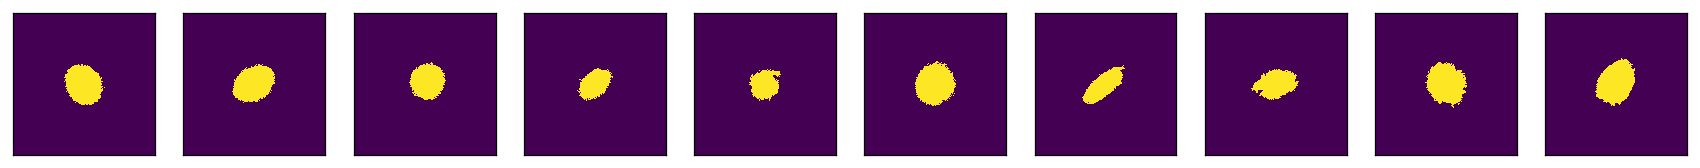

In [128]:
masks = get_segmentation_masks(bulk)
max_areas = [get_main_segm_region(x) for x in masks]
max_labels = [x[0] for x in max_areas]
galaxy_masks = [mask.keep_labels(label) for label, mask in zip(max_labels, masks)] 
show_segmentation(masks)
print([np.sum(mask.data == label) / len(mask.data) for label, mask in zip(max_labels, masks)] )

[68.95754716981132, 61.6438679245283, 43.75235849056604, 78.36320754716981, 85.30896226415095, 57.27594339622642, 62.18632075471698, 42.943396226415096, 16.92452830188679, 49.214622641509436]


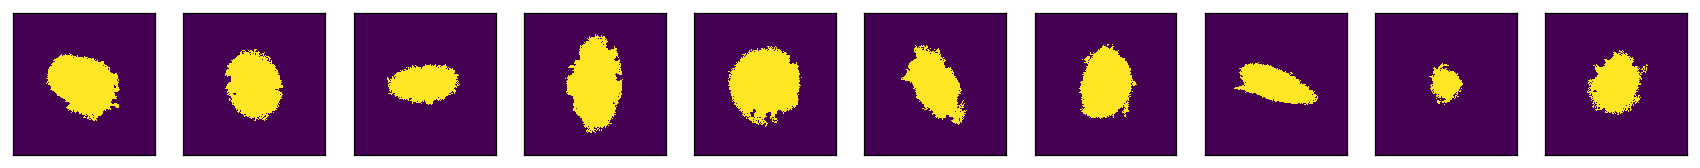

In [129]:
masks = get_segmentation_masks(top_right)
max_areas = [get_main_segm_region(x) for x in masks]
max_labels = [x[0] for x in max_areas]
galaxy_masks = [mask.keep_labels(label) for label, mask in zip(max_labels, masks)] 
show_segmentation(masks)
print([np.sum(mask.data == label) / len(mask.data) for label, mask in zip(max_labels, masks)] )

### Side note: these galaxies NOT larger on the sky, or physically larger - this seems to be purely a variation in framing

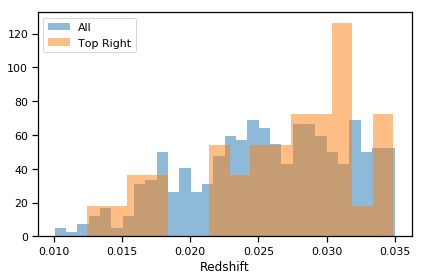

In [157]:
fig, ax = plt.subplots()
ax.hist(df['redshift'], density=True, alpha=0.5, bins=30, label='All')
ax.hist(top_right['redshift'], density=True, alpha=0.5, bins=15, label='Top Right')
ax.set_xlabel('Redshift')
ax.legend()
fig.tight_layout()

In [141]:
from astropy.cosmology import WMAP9 as cosmo
def get_kpc(galaxy):
    kpc_per_arcmin = cosmo.kpc_proper_per_arcmin(galaxy['redshift'])
    petroth_50_arcmin = galaxy['petroth50'] / 60.  # petroth50 is in arcsecs, I think
    kpc = petroth_50_arcmin * kpc_per_arcmin
    return kpc.value

In [145]:
top_right['kpc'] = top_right.apply(get_kpc, axis=1)
df['kpc'] = df.apply(get_kpc, axis=1)

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


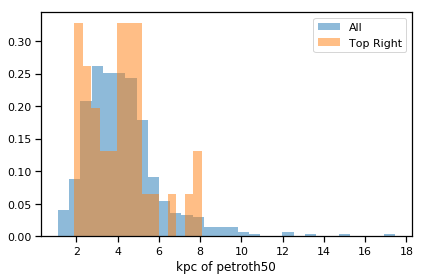

In [158]:
fig, ax = plt.subplots()
ax.hist(df['kpc'], density=True, alpha=0.5, bins=30, label='All')
ax.hist(top_right['kpc'], density=True, alpha=0.5, bins=15, label='Top Right')
ax.set_xlabel('kpc of petroth50')
ax.legend()
fig.tight_layout()

**So what is going on?**

Framing (in DECALS, and probably in GZ2) is controlled by `petroth50` and `petroth90`, aiming to make each galaxy appear about the same size. This works fairly well, but is imperfect. 

The badly framed galaxies also appear brighter (though I don't have numbers for that in this data). 
Possibly, these galaxies have very bright cores, which reduces `petroth50` and therefore the framing of the galaxy.

## Calculate % Area of Galaxy in Picture, for All Galaxies

In [96]:
@functools.lru_cache(2**8)
def get_galaxy_pc_area(file_loc):
    im = np.array(Image.open(file_loc))
    segm = get_segmentation_mask(im)
    max_area = get_main_segm_region(segm)
    max_label = max_area[0]
    area = np.sum(segm.data == max_label)
    return area / len(segm.data)

In [97]:
df['galaxy_pc_area'] = df['local_png_loc'].apply(get_galaxy_pc_area)

### % Area Correlates to Bulge Size

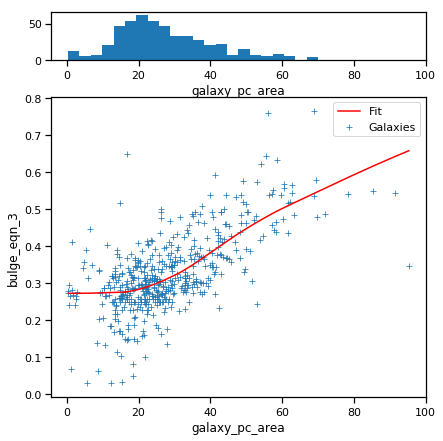

In [184]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(6, 6))
gs = gridspec.GridSpec(5, 3)
ax0 = plt.subplot(gs[0, :])
ax1 = plt.subplot(gs[1:, :])
plt.gcf().tight_layout()

ax0.hist(df['galaxy_pc_area'], bins=30)
ax0.set_xlabel('galaxy_pc_area')

sns.scatterplot(df['galaxy_pc_area'], df['bulge_eqn_3'],  ax=ax1, marker='+', label='Galaxies')
z = sm.nonparametric.lowess(df['bulge_eqn_3'], df['galaxy_pc_area'])
ax1.plot(z[:, 0], z[:, 1], c='r', label='Fit')
ax1.legend()

In [101]:
# fig, ax = plt.subplots()
# sns.scatterplot(df['galaxy_pc_area'], df['bulge_moderate-minus-small'],  ax=ax, marker='+', label='Galaxies')
# z = sm.nonparametric.lowess(df['bulge_moderate-minus-small'], df['galaxy_pc_area'])
# ax.plot(z[:, 0], z[:, 1], c='r', label='Fit')
# ax.legend()

*TODO I should think about how to correct for this effect, rather than just removing the galaxies?*

Bulge winding, following the Masters definition (and also moderate - small, not shown) is affected by galaxy visual extent. **When the galaxy is > 30% of the image, volunteers report larger bulge sizes.**

### % Area Does Not (Obviously) Correlate With Spiral Winding

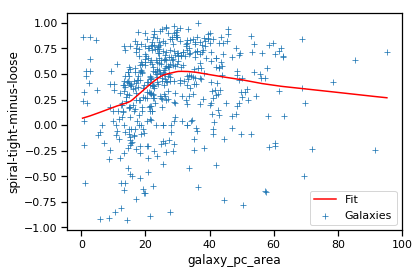

In [231]:
fig, ax = plt.subplots()
sns.scatterplot(df['galaxy_pc_area'], df['spiral-tight-minus-loose'],  ax=ax, marker='+', label='Galaxies')
z = sm.nonparametric.lowess(df['spiral-tight-minus-loose'], df['galaxy_pc_area'])
ax.plot(z[:, 0], z[:, 1], c='r', label='Fit')
ax.legend()


Spirals aren't obviously affected by galaxy visual extent - which I think is good news here, because that leads to the results above standing once we remove the badly-framed galaxies!

## Review Bulge-Winding Correlations with Badly-Framed Galaxies (% > 30) Removed

In [ ]:
moderate_df = df[df['galaxy_pc_area'] < 30] 

In [104]:

# fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
# sns.kdeplot(moderate_df['bulge_moderate-minus-small'], moderate_df['spiral-tight-minus-loose'], ax=ax0)
# sns.regplot(moderate_df['bulge_moderate-minus-small'], moderate_df['spiral-tight-minus-loose'], ax=ax1)
# ax0.set_xlim([-1, 0.])
# ax0.set_ylim([-.5, 1])
# ax0.set_xlabel('Bulge Moderate - Small')
# ax1.set_xlabel('Bulge Moderate - Small')
# ax0.set_ylabel('Spiral Tight - Loose')
# ax1.set_ylabel('')

In [186]:

# fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
# sns.kdeplot(moderate_df['bulge_moderate-minus-small'], moderate_df['winding_eqn_1'], ax=ax0)
# sns.regplot(moderate_df['bulge_moderate-minus-small'], moderate_df['winding_eqn_1'], ax=ax1)
# ax0.set_xlim([-1, 0.])
# ax0.set_ylim([0., 1])
# ax0.set_xlabel('Bulge Moderate - Small')
# ax1.set_xlabel('Bulge Moderate - Small')
# ax0.set_ylabel('Spiral Tight - Loose')
# ax1.set_ylabel('')

In [106]:
# fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
# sns.kdeplot(moderate_df['bulge_moderate-minus-small'], moderate_df['spiral-tight-minus-medium'], ax=ax0)
# sns.regplot(moderate_df['bulge_moderate-minus-small'], moderate_df['spiral-tight-minus-medium'], ax=ax1)
# ax0.set_xlim([-1, 0.])
# ax0.set_ylim([-.5, 1])
# ax0.set_xlabel('Bulge Moderate - Small')
# ax0.set_ylabel('Spiral Tight - Medium')
# ax1.set_xlabel('Bulge Moderate - Small')
# ax1.set_ylabel('')

### Masters 2019 on DECALS, Before and After Removal

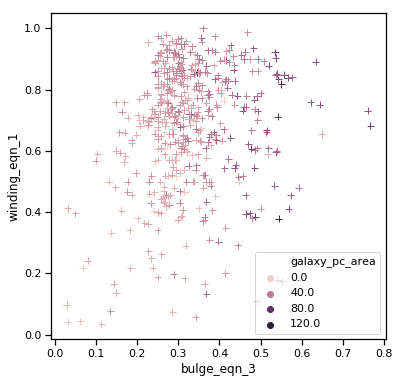

In [196]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(df['bulge_eqn_3'], df['winding_eqn_1'], s=50, edgecolor="b", linewidth=1., marker='+', hue=df['galaxy_pc_area'], ax=ax)

Large-area galaxies clearly have larger bulges. Removing them:

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'$B_{avg}$')

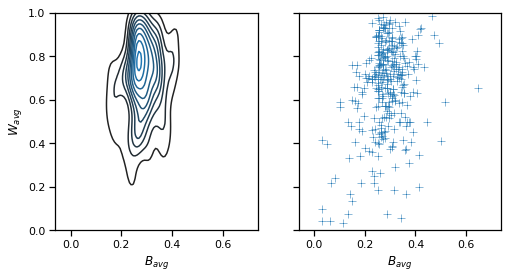

In [112]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
sns.kdeplot(moderate_df['bulge_eqn_3'], moderate_df['winding_eqn_1'], ax=ax0)
sns.scatterplot(moderate_df['bulge_eqn_3'], moderate_df['winding_eqn_1'], s=50, edgecolor="b", linewidth=.5, marker='+', ax=ax1)
# ax0.set_xlim([0, 1])
ax0.set_ylim([0, 1])
# ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax0.set_ylabel(r'$W_{avg}$')
ax0.set_xlabel(r'$B_{avg}$')
ax1.set_xlabel(r'$B_{avg}$')

Coloring by % area (left), we can confirm that galaxies with the largest bulges are bigger in the frame. **Removing them (right), the lack of a winding-bulge correlation still holds up.**

### Bulge Moderate - Small, before and after removal:

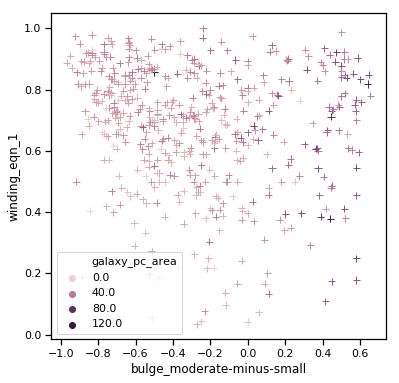

In [107]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(df['bulge_moderate-minus-small'], df['winding_eqn_1'], s=50, edgecolor="b", linewidth=1., marker='+', hue=df['galaxy_pc_area'], ax=ax)

/data/miniconda3/envs/zoobot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Bulge Moderate - Small')

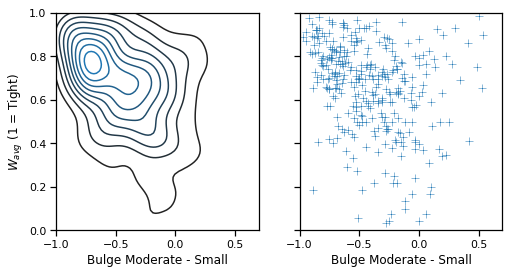

In [209]:
fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
sns.kdeplot(moderate_df['bulge_moderate-minus-small'], moderate_df['winding_eqn_1'], ax=ax0)
sns.scatterplot(moderate_df['bulge_moderate-minus-small'], moderate_df['winding_eqn_1'], s=50, edgecolor="b", linewidth=.5, marker='+', ax=ax1)
ax1.set_xlim([-1, .7])
ax0.set_ylim([0, 1])
ax1.set_xlim([-1, .7])
ax1.set_ylim([0, 1])
ax0.set_ylabel(r'$W_{avg}$ (1 = Tight)')
ax0.set_xlabel('Bulge Moderate - Small')
ax1.set_xlabel('Bulge Moderate - Small')

This anti-correlation (larger bulge -> looser spiral arms) is looking quite convincing now, though there is still plenty of outliers.

### Visualise the Outlier Populations

In [238]:
bulk = moderate_df[(moderate_df['bulge_moderate-minus-small'] < -0.2) & (moderate_df['winding_eqn_1'] > 0.3)]
top_right = moderate_df[(moderate_df['bulge_moderate-minus-small'] > 0.2) & (moderate_df['winding_eqn_1'] > 0.6)]
bottom = moderate_df[moderate_df['winding_eqn_1'] < 0.3]


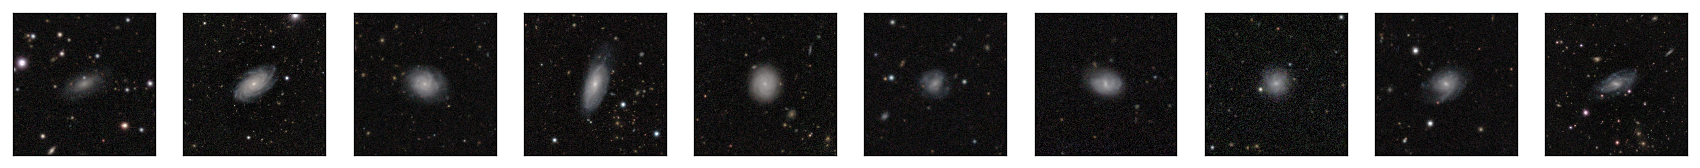

In [244]:
show_examples(bulk.sample(10))


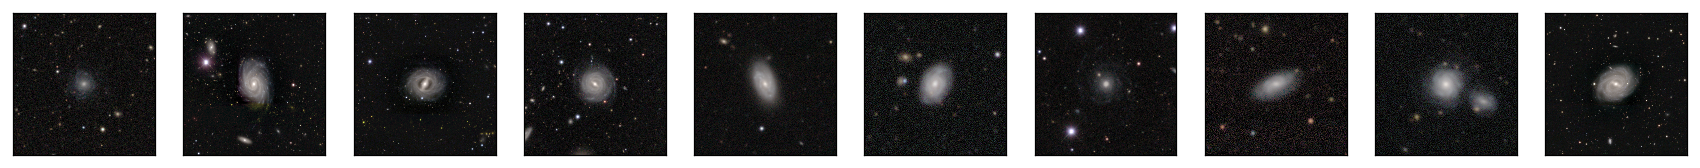

In [245]:
show_examples(top_right.sample(10))  # big bulge, tightly wound

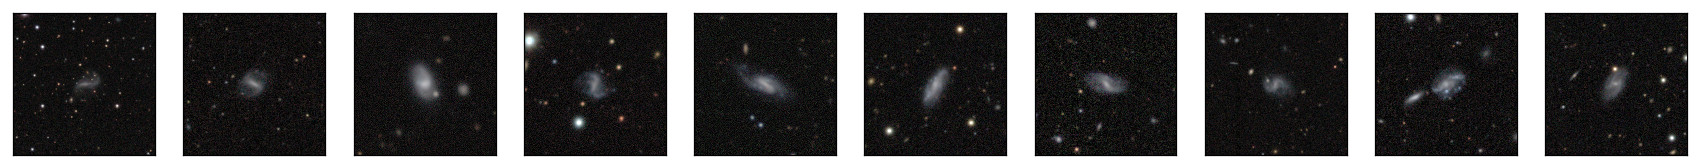

In [246]:
show_examples(bottom.sample(10))  # unusually low winding given the bulge size

I'm not sure what's different here!